In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import sklearn.metrics as metrics
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
from torch_geometric.utils import train_test_split_edges
import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch
import torch.optim as optim
import csv
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader
from torch_geometric.utils import train_test_split_edges
import torch_geometric.transforms as T
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data, DataLoader
from scipy import sparse
from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [2]:
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
#         self.conv1 = pyg_nn.GCNConv(in_channels, 2 * out_channels, cached=True)
#         self.conv2 = pyg_nn.GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv1 = pyg_nn.GraphConv(in_channels, 2 * out_channels)
        self.conv2 = pyg_nn.GraphConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)
    
def train(epoch,val_pos, val_neg):
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    loss.backward()
    optimizer.step()
    AUC, AP = model.test(z, val_pos, val_neg)
    return AUC,AP,loss.item()
#     writer.add_scalar("loss", loss.item(), epoch)
    
def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
        loss = model.recon_loss(z,pos_edge_index)
    AUC, AP = model.test(z, pos_edge_index, neg_edge_index)
    return AUC,AP,loss.item()



In [3]:
class MyOwnDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(MyOwnDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['some_file_1', 'some_file_2', ...]

    @property
    def processed_file_names(self):
#         pass
        return ['data.pt']

#     def download(self):
#         pass
#         Download to `self.raw_dir`.

    def process(self):
        # Read data into huge `Data` list.
        graph= nx.read_graphml("../data/transactions_16-12-15.graphml")
        graph=nx.Graph(graph)
        print("graph loaded!!!", nx.info(graph))
        features = np.load("../data/transactions_16-12-15.npy", allow_pickle= True)
        edge_features = []
#         max_deg = sorted(list(dict(nx.degree(graph)).values()),reverse = True)[0]
#         range_ = 100
        X =  []
        for n in graph.nodes():
            f_vect = torch.zeros((100+1,),dtype = torch.float)
            deg = nx.degree(graph, n)
#             bin_ = int((deg/max_deg)*range_)
            if deg>100:
                deg = 100
            f_vect[deg] = 1
            X.append(f_vect)
        X = torch.stack(X) 
#         dic = features.item()
#         for k, v in dic.items():
#             t = torch.zeros(len(v),dtype = torch.float)
#             for index in range(len(v)):
#                 t[index] = float(v[index])
#             edge_features.append(t)

#         edge_features = torch.stack(edge_features) 
        pyg_g = pyg_utils.from_networkx(graph)
        pyg_g.x= X
#         pyg_g.edge_attr = edge_features
        data_list = [pyg_g]
        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]
        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]
        print("dataset: ",len(data_list))
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])



In [4]:
path = '../data/transactions_16-12-15/'
# transform = T.OneHotDegree(max_degree=2)
# dataset = MyOwnDataset(path,transform = transform)
dataset = MyOwnDataset(path)

Processing...
graph loaded!!! Name: 
Type: Graph
Number of nodes: 37175
Number of edges: 56987
Average degree:   3.0659
dataset:  1
Done!


In [5]:
# writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

# dataset = Planetoid(root='/tmp/cora', name='cora')
# task = 'node'

# model = train(dataset, task, writer)

data = dataset[0]
channels = 8
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('CUDA availability:', torch.cuda.is_available())

# encoder: written by us; decoder: default (inner product)

print("data loaded successfully!!")
data.train_mask = data.val_mask = data.test_mask = data.y = None
data = train_test_split_edges(data,val_ratio=0.0, test_ratio=0.1)
print(data)
x, train_pos_edge_index = data.x.to(dev), data.train_pos_edge_index.to(dev)


CUDA availability: False
data loaded successfully!!
Data(test_neg_edge_index=[2, 5696], test_pos_edge_index=[2, 5696], train_neg_adj_mask=[37175, 37175], train_pos_edge_index=[2, 102532], val_neg_edge_index=[2, 0], val_pos_edge_index=[2, 0], x=[37175, 101])


In [6]:
model = pyg_nn.GAE(Encoder(dataset.num_features, channels)).to(dev)
labels = data.y
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print("now training the model")
AUC_, AP_,AUC_train, AP_train,train_loss,test_loss = [],[],[],[],[],[]
for epoch in range(0, 100):
    AUC_tr, AP_tr,tr_loss = train(epoch,data.test_pos_edge_index, data.test_neg_edge_index)
    AUC_train.append(AUC_tr)
    AP_train.append(AP_tr)
    auc, ap,test_l= test(data.test_pos_edge_index, data.test_neg_edge_index)
    AUC_.append(auc)
    AP_.append(ap)
    train_loss.append(tr_loss)
    test_loss.append(test_l)
#     writer.add_scalar("AUC", auc, epoch)
#     writer.add_scalar("AP", ap, epoch)
#     if epoch % 10 == 0:
    print('Epoch: {:03d}, AUC_train: {:.4f},AUC_test:{:.4f} loss_train: {:.4f}, loss_test:{:.4f}'.format(epoch, AUC_tr, auc,tr_loss, test_l))

now training the model
Epoch: 000, AUC_train: 0.4895,AUC_test:0.4627 loss_train: 29.0987, loss_test:26.5707
Epoch: 001, AUC_train: 0.4627,AUC_test:0.4376 loss_train: 26.4207, loss_test:25.2778
Epoch: 002, AUC_train: 0.4376,AUC_test:0.4144 loss_train: 25.3043, loss_test:26.4616
Epoch: 003, AUC_train: 0.4144,AUC_test:0.4010 loss_train: 24.4348, loss_test:28.8135
Epoch: 004, AUC_train: 0.4010,AUC_test:0.3917 loss_train: 24.3494, loss_test:30.9319
Epoch: 005, AUC_train: 0.3917,AUC_test:0.3889 loss_train: 24.2373, loss_test:31.1085
Epoch: 006, AUC_train: 0.3889,AUC_test:0.3886 loss_train: 24.1054, loss_test:31.1919
Epoch: 007, AUC_train: 0.3886,AUC_test:0.3883 loss_train: 23.9061, loss_test:30.8935
Epoch: 008, AUC_train: 0.3883,AUC_test:0.3877 loss_train: 23.6641, loss_test:30.4687
Epoch: 009, AUC_train: 0.3877,AUC_test:0.3835 loss_train: 23.8676, loss_test:31.0255
Epoch: 010, AUC_train: 0.3835,AUC_test:0.3792 loss_train: 23.2046, loss_test:31.1332
Epoch: 011, AUC_train: 0.3792,AUC_test:0.3

Epoch: 098, AUC_train: 0.9156,AUC_test:0.9156 loss_train: 3.1313, loss_test:3.3268
Epoch: 099, AUC_train: 0.9156,AUC_test:0.9159 loss_train: 3.0961, loss_test:3.2537


In [7]:
file = open("results_transactions_16-12-15.csv",'a',newline = '')
res_writer = csv.writer(file, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
res_writer.writerow(["sequence => auc_train","auc_test","ap_train","ap_test","train loss","test loss"])
res_writer.writerow(AUC_train)
res_writer.writerow(AUC_)
res_writer.writerow(AP_train)
res_writer.writerow(AP_)
res_writer.writerow(train_loss)
res_writer.writerow(test_loss)
file.flush()
file.close()

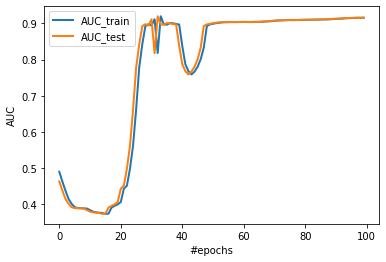

In [8]:
fig = plt.figure()

plt.plot(AUC_train[:100],linewidth=2, label = 'AUC_train')
plt.plot(AUC_[:100],linewidth=2, label = 'AUC_test')
plt.legend()
plt.xlabel("#epochs")
plt.ylabel("AUC")
plt.show()
fig.savefig("../figures/transactions_16-12-15_AUC_curves1-new.pdf")

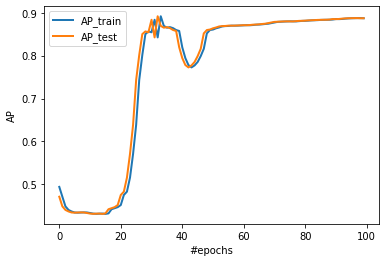

In [9]:
fig = plt.figure()

plt.plot(AP_train[:100],linewidth=2, label = 'AP_train')
plt.plot(AP_[:100],linewidth=2, label = 'AP_test')
plt.legend()
plt.xlabel("#epochs")
plt.ylabel("AP")
plt.show()
fig.savefig("../figures/transactions_16-12-15_AP_curves1-new.pdf")

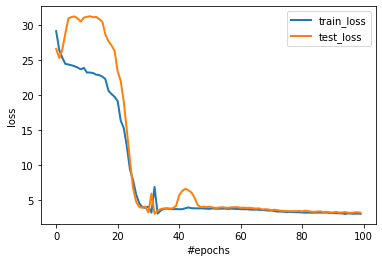

In [10]:
fig = plt.figure()
plt.plot(train_loss[:100],linewidth=2, label = 'train_loss')
plt.plot(test_loss[:100],linewidth=2, label = 'test_loss')
plt.legend()
plt.xlabel("#epochs")
plt.ylabel("loss")
plt.show()
fig.savefig("../figures/transactions_16-12-15_loss_curves1-new.pdf")

In [4]:
graph= nx.read_graphml("data/transactions_16-12-11.graphml")
graph=nx.Graph(graph)
print("graph loaded!!!", nx.info(graph))
deg = sorted(list(dict(nx.degree(graph)).values()),reverse = True)

graph loaded!!! Name: 
Type: Graph
Number of nodes: 34822
Number of edges: 53870
Average degree:   3.0940
